# Hello Wolt!

In [1]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


First, we start with importing all the necessary libraries

In [2]:
DIRECTORY = './input/'

locations = pd.read_csv(DIRECTORY + 'locations.csv')
pickup_times = pd.read_csv(DIRECTORY + 'pickup_times.csv')
pickup_times['date'] = pd.to_datetime(pickup_times['iso_8601_timestamp'])
pickup_times = pickup_times.drop(['iso_8601_timestamp'], axis=1)

Next we load `locations` and `pickup_times` datasets.

For `pickup_times` I parse the time into Pandas Timestamp, which is more comfortoble to work with.

In [3]:
def prepare_date(df_date):
    weekdays_one_hot_df = pd.get_dummies(df_date.map(lambda x: x.dayofweek))
    time_flat_series = df_date.map(lambda a: (a.hour-10)/10 + a.minute/600)
    
    weekdays_one_hot_df['time'] = time_flat_series
    return weekdays_one_hot_df

In the `prepare_date` function we import `dates` column from `pickup_times` and:
 1. Parse weekdays and create one-hot encoded dataframe like `[1,0,0,0,0,0,0]` where `1` on 0th place represent monday. [One-how encoding](https://en.wikipedia.org/wiki/One-hot)
 2. We encode the pickup time into simple value in range [0, 1]. Knowing that delivery day in Wolt is 10 hours we can simply take an hour (staring with 0 to 10, where 0 is 10AM and 10 is 8PM) and divide it by 10 and add minute divided by 600 (so that new minute value will be in range[0, 0.1] and nicely represent one hour).
 3. Return the result as merged series.

In [4]:
def prepare_for_nn(df):
    dates = prepare_date(df['date'])
    places_dummies = pd.get_dummies(df['location_id']) # 85 locations
    
    return pd.concat([dates, places_dummies], axis=1).values, (df['pickup_time']/90).values

X, y = prepare_for_nn(pickup_times)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Atfer that, we merge dates, which came from the previous step, with places ids, which are also One-Hot encoded.
Then, just split into training/testing datasets.

In [8]:
model = Sequential()

model.add(Dense(124, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(256, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(512, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(256, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(124, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])

Here we define a model with 11 layers: 5 hidden layers with 124-512 scaled exponential linear units, 5 dropout layers, and one output sigmoid layer.

Then we will run model learning with 200 epochs.

In [9]:
history = model.fit(X, y, epochs=200, validation_split = 0.2, batch_size=128, verbose=1)

Train on 52304 samples, validate on 13076 samples
Epoch 1/200
52304/52304 [==============================] - 3s 49us/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0841 - mean_absolute_percentage_error: 44.2714 - cosine_proximity: -1.0000 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0793 - val_mean_absolute_percentage_error: 43.5553 - val_cosine_proximity: -1.0000
Epoch 2/200
52304/52304 [==============================] - 2s 41us/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0802 - mean_absolute_percentage_error: 42.4412 - cosine_proximity: -1.0000 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0769 - val_mean_absolute_percentage_error: 40.8406 - val_cosine_proximity: -1.0000
Epoch 3/200
52304/52304 [==============================] - 2s 42us/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0785 - mean_absolute_percentage_error: 41.3847 - 

52304/52304 [==============================] - 2s 41us/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0730 - mean_absolute_percentage_error: 37.5400 - cosine_proximity: -1.0000 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 37.1329 - val_cosine_proximity: -1.0000
Epoch 23/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0726 - mean_absolute_percentage_error: 37.3292 - cosine_proximity: -1.0000 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0718 - val_mean_absolute_percentage_error: 38.0045 - val_cosine_proximity: -1.0000
Epoch 24/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0729 - mean_absolute_percentage_error: 37.4175 - cosine_proximity: -1.0000 - val_loss: 0.0081 - val_mean_squa

52304/52304 [==============================] - 2s 41us/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 36.8603 - cosine_proximity: -1.0000 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0708 - val_mean_absolute_percentage_error: 37.2113 - val_cosine_proximity: -1.0000
Epoch 44/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0716 - mean_absolute_percentage_error: 36.6640 - cosine_proximity: -1.0000 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0703 - val_mean_absolute_percentage_error: 34.8824 - val_cosine_proximity: -1.0000
Epoch 45/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 36.7363 - cosine_proximity: -1.0000 - val_loss: 0.0078 - val_mean_squa

52304/52304 [==============================] - 2s 41us/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0708 - mean_absolute_percentage_error: 36.1841 - cosine_proximity: -1.0000 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0699 - val_mean_absolute_percentage_error: 34.9788 - val_cosine_proximity: -1.0000
Epoch 65/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0709 - mean_absolute_percentage_error: 36.2009 - cosine_proximity: -1.0000 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0703 - val_mean_absolute_percentage_error: 36.7093 - val_cosine_proximity: -1.0000
Epoch 66/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0708 - mean_absolute_percentage_error: 36.1308 - cosine_proximity: -1.0000 - val_loss: 0.0078 - val_mean_squa

52304/52304 [==============================] - 2s 41us/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0702 - mean_absolute_percentage_error: 35.7662 - cosine_proximity: -1.0000 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0689 - val_mean_absolute_percentage_error: 34.1025 - val_cosine_proximity: -1.0000
Epoch 86/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0703 - mean_absolute_percentage_error: 35.8392 - cosine_proximity: -1.0000 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0692 - val_mean_absolute_percentage_error: 34.7102 - val_cosine_proximity: -1.0000
Epoch 87/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0704 - mean_absolute_percentage_error: 35.8329 - cosine_proximity: -1.0000 - val_loss: 0.0074 - val_mean_squa

52304/52304 [==============================] - 2s 41us/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0697 - mean_absolute_percentage_error: 35.4600 - cosine_proximity: -1.0000 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0691 - val_mean_absolute_percentage_error: 34.8745 - val_cosine_proximity: -1.0000
Epoch 107/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0698 - mean_absolute_percentage_error: 35.5346 - cosine_proximity: -1.0000 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0701 - val_mean_absolute_percentage_error: 37.0656 - val_cosine_proximity: -1.0000
Epoch 108/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0697 - mean_absolute_percentage_error: 35.5309 - cosine_proximity: -1.0000 - val_loss: 0.0074 - val_mean_sq

52304/52304 [==============================] - 2s 41us/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0696 - mean_absolute_percentage_error: 35.3995 - cosine_proximity: -1.0000 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0687 - val_mean_absolute_percentage_error: 34.5980 - val_cosine_proximity: -1.0000
Epoch 128/200
52304/52304 [==============================] - 2s 41us/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0694 - mean_absolute_percentage_error: 35.2447 - cosine_proximity: -1.0000 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0694 - val_mean_absolute_percentage_error: 34.8080 - val_cosine_proximity: -1.0000
Epoch 129/200
52304/52304 [==============================] - 2s 41us/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0696 - mean_absolute_percentage_error: 35.3280 - cosine_proximity: -1.0000 - val_loss: 0.0073 - val_mean_sq

52304/52304 [==============================] - 2s 41us/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0692 - mean_absolute_percentage_error: 35.1315 - cosine_proximity: -1.0000 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0694 - val_mean_absolute_percentage_error: 35.7647 - val_cosine_proximity: -1.0000
Epoch 149/200
52304/52304 [==============================] - 2s 41us/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0692 - mean_absolute_percentage_error: 35.1690 - cosine_proximity: -1.0000 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0687 - val_mean_absolute_percentage_error: 34.8682 - val_cosine_proximity: -1.0000
Epoch 150/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0695 - mean_absolute_percentage_error: 35.2116 - cosine_proximity: -1.0000 - val_loss: 0.0073 - val_mean_sq

52304/52304 [==============================] - 2s 41us/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0694 - mean_absolute_percentage_error: 35.1831 - cosine_proximity: -1.0000 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0693 - val_mean_absolute_percentage_error: 33.9521 - val_cosine_proximity: -1.0000
Epoch 170/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0690 - mean_absolute_percentage_error: 35.0337 - cosine_proximity: -1.0000 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0687 - val_mean_absolute_percentage_error: 32.9728 - val_cosine_proximity: -1.0000
Epoch 171/200
52304/52304 [==============================] - 2s 41us/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0689 - mean_absolute_percentage_error: 34.9649 - cosine_proximity: -1.0000 - val_loss: 0.0072 - val_mean_sq

52304/52304 [==============================] - 2s 40us/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0689 - mean_absolute_percentage_error: 34.9455 - cosine_proximity: -1.0000 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0685 - val_mean_absolute_percentage_error: 34.6278 - val_cosine_proximity: -1.0000
Epoch 191/200
52304/52304 [==============================] - 2s 40us/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0689 - mean_absolute_percentage_error: 34.9759 - cosine_proximity: -1.0000 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0686 - val_mean_absolute_percentage_error: 33.6300 - val_cosine_proximity: -1.0000
Epoch 192/200
52304/52304 [==============================] - 2s 41us/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0689 - mean_absolute_percentage_error: 34.9420 - cosine_proximity: -1.0000 - val_loss: 0.0072 - val_mean_sq

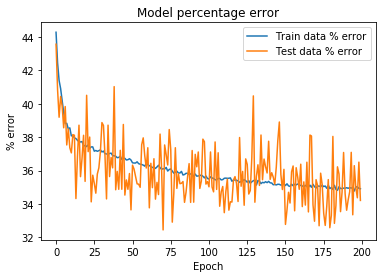

In [15]:
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('Model percentage error')
plt.ylabel('% error')
plt.xlabel('Epoch')
plt.legend(['Train data % error', 'Test data % error'], loc='upper right')
plt.show()

The plot above shows how the model lowers the error during the learning process.

# Conclusion

With only given dataset we can predict how long the pickup time will be with at max ~35% error. The error will decrease with extra data given in. It can be past delivery data, weather conditions, traffic in the city